# Images for text

100%|██████████| 50/50 [00:03<00:00, 15.96it/s]


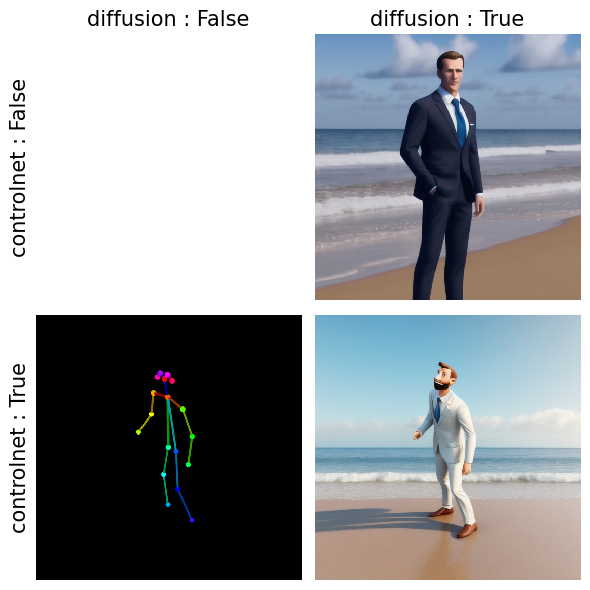

In [58]:
import seaborn_image as isns
import torch
import numpy as np
from diffusers import AutoencoderKL, ControlNetModel, MotionAdapter
from diffusers.pipelines import (
    AutoPipelineForText2Image,
    StableDiffusionControlNetPipeline,
)
from PIL import Image
import matplotlib.pyplot as plt

generator = torch.Generator(device="cuda").manual_seed(12)

isns.set_save_context(dpi=300)
isns.set_context("paper", fontweight="normal")

prompt = "animated man in suit standing on a beach, best quality, masterpiece"

controlnet_image = Image.open("data/controlnet_openpose.png")

model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16
)

pipe = AutoPipelineForText2Image.from_pretrained(
    model_id, torch_dtype=torch.float16
).to("cuda")

pipe_controlnet = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

output = np.array(pipe(prompt, generator=generator).images[0])
output_controlnet = np.array(pipe_controlnet(prompt, image=controlnet_image, generator=generator).images[0])


def map_func(*args, **kwargs):
    if not kwargs["controlnet"] and not kwargs["diffusion"]:
        return np.ones_like(output) * 255
    elif kwargs["controlnet"] and kwargs["diffusion"]:
        return output_controlnet
    elif kwargs["controlnet"] and not kwargs["diffusion"]:
        return np.array(controlnet_image)
    return output


g = isns.ParamGrid(
    output,
    row="controlnet",
    col="diffusion",
    map_func=map_func,
    controlnet=[False, True],
    diffusion=[False, True],
    despine=True
)

plt.savefig("images/controlnet.png")

100%|██████████| 50/50 [00:03<00:00, 15.08it/s]


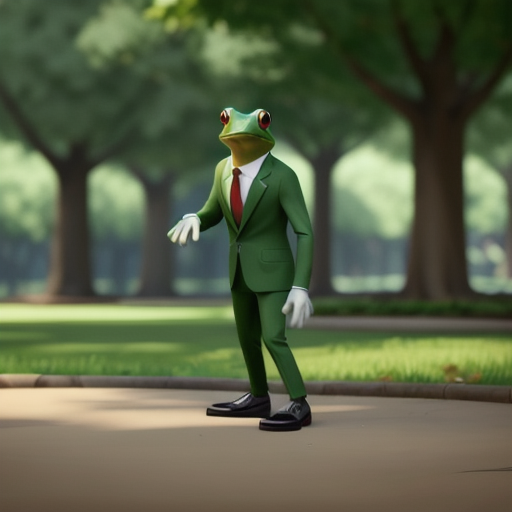

In [29]:
import seaborn_image as isns
import torch
import numpy as np
from diffusers import AutoencoderKL, ControlNetModel, MotionAdapter
from diffusers.pipelines import (
    AutoPipelineForText2Image,
    StableDiffusionControlNetPipeline,
)
from PIL import Image
import matplotlib.pyplot as plt

isns.set_save_context(dpi=300)
isns.set_context("paper", fontweight="normal")

prompt = "stylized animation of frog character in suit standing in park, best quality, masterpiece"

controlnet_image = Image.open("data/controlnet_openpose.png")

model_id = "SG161222/Realistic_Vision_V5.1_noVAE"
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float16
)

pipe_controlnet = StableDiffusionControlNetPipeline.from_pretrained(
    model_id, controlnet=controlnet, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")

pipe_controlnet(prompt, image=controlnet_image).images[0]

100%|██████████| 50/50 [00:02<00:00, 17.19it/s]


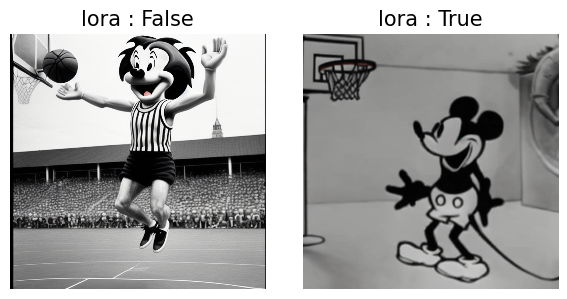

In [77]:
import seaborn_image as isns
import torch
import numpy as np
from diffusers import AutoencoderKL, ControlNetModel, MotionAdapter
from diffusers.pipelines import (
    AutoPipelineForText2Image,
    StableDiffusionControlNetPipeline,
)
from PIL import Image
import matplotlib.pyplot as plt

generator = torch.Generator(device="cuda").manual_seed(11)

isns.set_save_context(dpi=300)
isns.set_context("paper", fontweight="normal")

prompt = "steamboat willie jumping, playing basketball, best quality, masterpiece"

model_id = "SG161222/Realistic_Vision_V5.1_noVAE"

pipe = AutoPipelineForText2Image.from_pretrained(
    model_id, torch_dtype=torch.float16
).to("cuda")

pipe_lora = AutoPipelineForText2Image.from_pretrained(
    model_id, torch_dtype=torch.float16, use_safetensors=True
).to("cuda")
pipe_lora.load_lora_weights("lora/Willie.safetensors", 'willie')
pipe.set_adapters(["willie"], adapter_weights=[0.8])

output = np.array(pipe(prompt, generator=generator).images[0])
output_lora = np.array(pipe_lora(prompt, generator=generator).images[0])

def map_func(*args, **kwargs):
    if kwargs["lora"]:
        return output_lora
    return output


g = isns.ParamGrid(
    output,
    col="lora",
    map_func=map_func,
    lora=[False, True],
    despine=True
)

plt.savefig("images/lora.png")

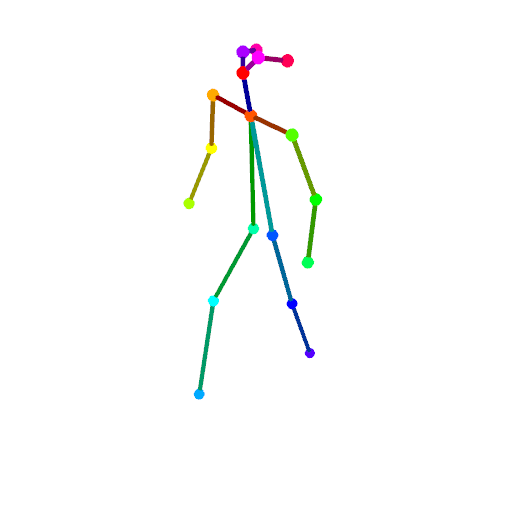

In [21]:
from PIL import Image
import numpy as np
from mayavi import mlab
from pyvirtualdisplay import Display
from tqdm import tqdm
import util
import logging
import torch

logger = logging.getLogger(__name__)

motion = torch.load("cache/motion.pt")

joints = [
    (1, "#0055FF"),
    (2, "#00FFAA"),
    (4, "#0000FF"),
    (5, "#00FFFF"),
    (7, "#5500FF"),
    (8, "#00AAFF"),
    (9, "#FF5500"),
    (12, "#FF0000"),
    (16, "#55FF00"),
    (17, "#FFAA00"),
    (18, "#00FF00"),
    (19, "#FFFF00"),
    (20, "#00FF55"),
    (21, "#AAFF00"),
    (22, "#FF0055"),
    (23, "#FF00FF"),
    (24, "#FF00AA"),
    (25, "#AA00FF"),
]

connections = [
    ((9, 1), "#009999"),
    ((1, 4), "#006699"),
    ((4, 7), "#003399"),
    ((9, 2), "#009900"),
    ((2, 5), "#009933"),
    ((5, 8), "#009966"),
    ((17, 19), "#996600"),
    ((19, 21), "#999900"),
    ((16, 18), "#669900"),
    ((18, 20), "#339900"),
    ((16, 9), "#993300"),
    ((17, 9), "#990000"),
    ((9, 12), "#000099"),
    ((22, 23), "#990066"),
    ((23, 12), "#990099"),
    ((24, 25), "#660099"),
    ((25, 12), "#330099"),
]

# Create virtual display for rendering offscreen
display = Display(visible=0, size=(1280, 1024))
display.start()


logger.info("Rendering conditioning openpose frames")

# Enable offscreen rendering
mlab.options.offscreen = True

# Create mayavi figure
figure = mlab.figure(size=(512, 512), bgcolor=(1, 1, 1))
mlab.clf()

# Expand motion array for head and eye joints
motion = np.concatenate((motion, np.zeros((4, 3, motion.shape[2]))), axis=0)

# Disable rendering for faster loading
figure.scene.disable_render = True

# Create level geometry
balls = []
lines = []
i = 0
for joint in joints:
    p = mlab.points3d(
        motion[joint[0]][2][i],
        motion[joint[0]][0][i],
        motion[joint[0]][1][i],
        color=util.hex_to_tuple(joint[1]),
        scale_factor=0.05,
    )
    p.actor.property.lighting = False
    balls.append(p)
for con in connections:
    c = mlab.plot3d(
        [motion[con[0][0]][2][i], motion[con[0][1]][2][i]],
        [motion[con[0][0]][0][i], motion[con[0][1]][0][i]],
        [motion[con[0][0]][1][i], motion[con[0][1]][1][i]],
        color=util.hex_to_tuple(con[1]),
        tube_radius=0.01,
    )
    c.actor.property.lighting = False
    lines.append(c)

# Set camera position
mlab.view(distance=4)

# Calculate default vector from camera to neck joint
neck = [motion[9][2][i], motion[9][0][i], motion[9][1][2]]
cam, _ = mlab.move()
to_cam = neck - cam

camera_motions = []

# Frame by frame rendering
images = []

# Disable rendering when manipulating geometry position
figure.scene.disable_render = True

# Calculate neck joint (center of shoulders)
for j in range(3):
    motion[9][j][i] = (motion[13][j][i] + motion[14][j][i]) / 2

# Calculate normal vector from points 9, 12, 15 (neck, head, and nose joints)
p1 = np.array([motion[9][0][i], motion[9][1][i], motion[9][2][i]])
p2 = np.array([motion[12][0][i], motion[12][1][i], motion[12][2][i]])
p3 = np.array([motion[15][0][i], motion[15][1][i], motion[15][2][i]])
v1 = p2 - p1
v2 = p3 - p1
cp = np.cross(v1, v2)
cp = (cp / np.linalg.norm(cp)) / 12

# Calculate eye vector
eye_vec = (v1 / np.linalg.norm(v1)) / 20

# Make head bigger (multiply by 2)
for j in range(3):
    motion[12][j][i] = (
        motion[9][j][i] + (motion[12][j][i] - motion[9][j][i]) * 2
    )

    # Calculate vector from nose to back of head
    back_vec = -np.cross(cp, eye_vec)
    back_vec = (back_vec / np.linalg.norm(back_vec)) / 20

# Calculate eye and head joint positions
for j in range(3):
    # Left ear
    motion[22][j][i] = motion[12][j][i] + cp[j] + back_vec[j] * 3
    # Left eye
    motion[23][j][i] = motion[12][j][i] + cp[j] * 0.5 + eye_vec[j] + back_vec[j]
    # Right ear
    motion[24][j][i] = motion[12][j][i] + -cp[j] + back_vec[j] * 3
    # Right eye
    motion[25][j][i] = (
        motion[12][j][i] + -cp[j] * 0.5 + eye_vec[j] + back_vec[j]
    )

# Update geometry
for j, joint in enumerate(joints):
    balls[j].mlab_source.set(
        x=motion[joint[0]][2][i],
        y=motion[joint[0]][0][i],
        z=motion[joint[0]][1][i],
    )
for j, con in enumerate(connections):
    lines[j].mlab_source.set(
        x=[motion[con[0][0]][2][i], motion[con[0][1]][2][i]],
        y=[motion[con[0][0]][0][i], motion[con[0][1]][0][i]],
        z=[motion[con[0][0]][1][i], motion[con[0][1]][1][i]],
    )

# Print neck
neck = [motion[9][2][i], motion[9][0][i], motion[9][1][2]]
cam, _ = mlab.move()
move = cam - neck + to_cam
if np.linalg.norm([move[0], move[1]]) > 0.5:
    multiplier = 0.1
    x, y = move[0] * multiplier, move[1] * multiplier
    camera_motions.append((x, y))
    mlab.move([x, y, 0])
else:
    camera_motions.append((0.0, 0.0))

# Re-enable rendering
figure.scene.disable_render = False

# Capture frame
img = mlab.screenshot()

Image.fromarray(img)

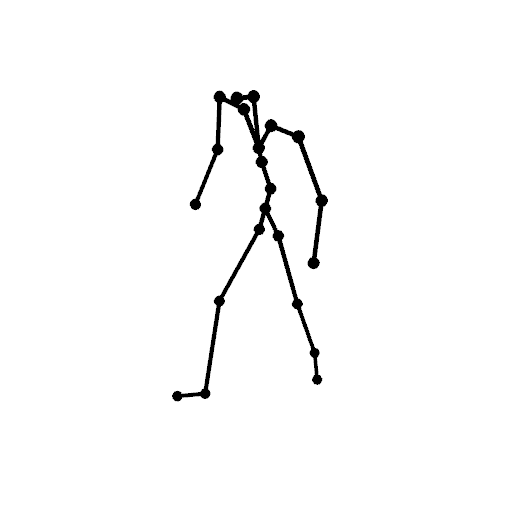

In [13]:
from PIL import Image
import numpy as np
from mayavi import mlab
from pyvirtualdisplay import Display
from tqdm import tqdm
import util
import logging
import torch

logger = logging.getLogger(__name__)

motion = torch.load("cache/motion.pt")

motion.shape

connections = [
    (8,11),
    (8,5),
    (2,5),
    (2,0),
    (7,10),
    (7,4),
    (1,4),
    (1,0),
    (0,3),
    (3,6),
    (6,9),
    (9,12),
    (12,15),
    (9,13),
    (13,16),
    (16,18),
    (18,20),
    (9,14),
    (14,17),
    (17,19),
    (19,21)
]

# Create virtual display for rendering offscreen
display = Display(visible=0, size=(1280, 1024))
display.start()


logger.info("Rendering conditioning openpose frames")

# Enable offscreen rendering
mlab.options.offscreen = True

# Create mayavi figure
figure = mlab.figure(size=(512, 512), bgcolor=(1, 1, 1))
mlab.clf()

# Disable rendering for faster loading
figure.scene.disable_render = True

# Create level geometry
balls = []
lines = []
i = 0
for j in range(22):
    p = mlab.points3d(
        motion[j][2][i],
        motion[j][0][i],
        motion[j][1][i],
        color=(0,0,0),
        scale_factor=0.05,
    )
    p.actor.property.lighting = False
    balls.append(p)
for con in connections:
    c = mlab.plot3d(
        [motion[con[0]][2][i], motion[con[1]][2][i]],
        [motion[con[0]][0][i], motion[con[1]][0][i]],
        [motion[con[0]][1][i], motion[con[1]][1][i]],
        color=(0,0,0),
        tube_radius=0.01,
    )
    c.actor.property.lighting = False
    lines.append(c)

# Set camera position
mlab.view(distance=4)

# Calculate default vector from camera to neck joint
neck = [motion[9][2][i], motion[9][0][i], motion[9][1][2]]
cam, _ = mlab.move()
to_cam = neck - cam

camera_motions = []

# Frame by frame rendering
images = []

# Disable rendering when manipulating geometry position
figure.scene.disable_render = True

# Update geometry
for j in range(22):
    balls[j].mlab_source.set(
        x=motion[j][2][i],
        y=motion[j][0][i],
        z=motion[j][1][i],
    )
for j, con in enumerate(connections):
    lines[j].mlab_source.set(
        x=[motion[con[0]][2][i], motion[con[1]][2][i]],
        y=[motion[con[0]][0][i], motion[con[1]][0][i]],
        z=[motion[con[0]][1][i], motion[con[1]][1][i]],
    )

# Print neck
neck = [motion[9][2][i], motion[9][0][i], motion[9][1][2]]
cam, _ = mlab.move()
move = cam - neck + to_cam
if np.linalg.norm([move[0], move[1]]) > 0.5:
    multiplier = 0.1
    x, y = move[0] * multiplier, move[1] * multiplier
    camera_motions.append((x, y))
    mlab.move([x, y, 0])
else:
    camera_motions.append((0.0, 0.0))

# Re-enable rendering
figure.scene.disable_render = False

# Capture frame
img = mlab.screenshot()

Image.fromarray(img)

Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]
0it [00:00, ?it/s]
100%|██████████| 22/22 [00:05<00:00,  3.96it/s]


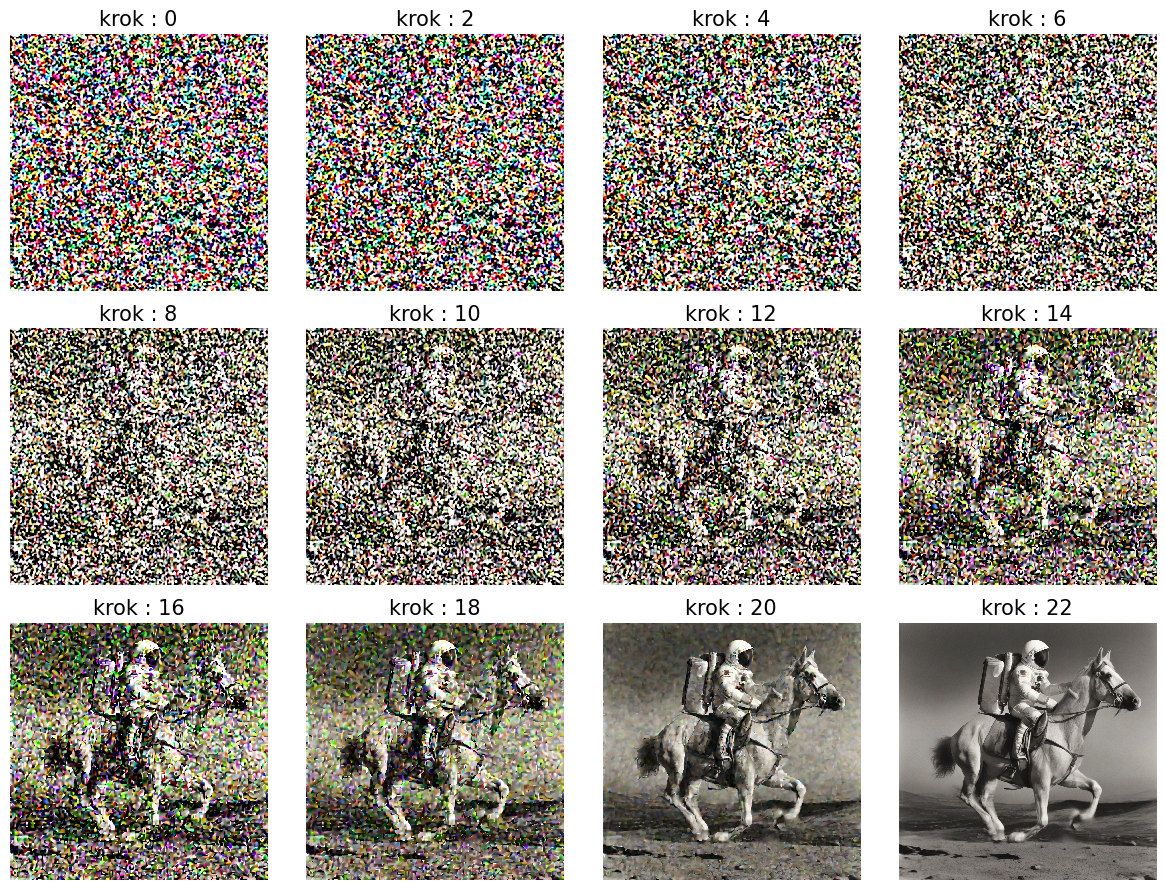

In [16]:
from diffusers import StableDiffusionXLPipeline
import seaborn_image as isns
import matplotlib.pyplot as plt
from PIL import Image
import torch

pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16
).to("cuda")
prompt = "a photograph of an astronaut riding a horse"

img = Image.new("RGB", (512, 512))

def do_diffusion(*args, krok=None):
    steps = 22
    denoising_end = krok/steps
    if denoising_end == 0:
        denoising_end = 1e-5
    generator = torch.Generator(device="cuda").manual_seed(30)
    return pipe(
        prompt,
        generator=generator,
        denoising_end=denoising_end,
        num_inference_steps=steps,
    ).images[0]

g = isns.ParamGrid(img, map_func=do_diffusion, col="krok", cbar=False, despine=True, krok=[0,2,4,6,8,10,12,14,16,18,20,22], col_wrap=4)
plt.savefig("images/steps.png")